# **Stamatics Summer Project**

## **Bayesian Ranking and Analysis of Investment Strategies**

### **Assignment 1**

### Problem Statement 1: Data Exploration & Visualization

1. Obtaining Data
Download 1 year of daily OHLCV data for any one stock of your choice listed on the National Stock Exchange (NSE) using yfinance. Clean and inspect the data: handle missing values and ensure datetime indexing. Refer to the resources to see a sample implementation.

In [ ]:
#Step 1: Install & Import Required Libraries
!pip install yfinance plotly mplfinance --quiet

import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set some display options
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

In [ ]:
# Step 2: Download Stock Data

def download_flat_yf(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, progress=False)
    data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None
    return data

stock_symbol = 'TITAN.NS'

data = download_flat_yf(stock_symbol, start='2024-05-30', end='2025-05-30')
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2024-05-30,3261.179199,3354.025300,3243.387318,3354.025300,2365535
2024-05-31,3231.326660,3317.943388,3206.258783,3287.243791,2524214
2024-06-03,3250.563721,3322.079712,3239.400298,3299.204611,1378542
2024-06-04,3228.386230,3284.452773,3045.684008,3250.563663,2934800
2024-06-05,3306.829590,3323.126363,3190.610020,3255.348141,1396386


In [ ]:
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [ ]:
data.describe()

,Close,High,Low,Open,Volume
count,248.000000,248.000000,248.000000,248.000000,2.480000e+02
mean,3378.022369,3416.028221,3339.517515,3378.046735,1.182638e+06
std,185.885873,188.510725,185.515043,187.240687,7.796967e+05
min,2986.949951,3017.350098,2925.000000,2925.000000,0.000000e+00
25%,3252.503357,3284.089580,3214.549988,3250.000000,7.076948e+05
50%,3366.799927,3408.124642,3331.000000,3368.162657,1.017890e+06
75%,3487.850037,3525.612488,3446.637512,3488.237427,1.383338e+06
max,3823.949951,3867.000000,3786.000000,3823.949951,7.159507e+06


2. Visual Insight
Plot an interactive candlestick chart using plotly.graph objects or mplfinance. A sample implementation is available in the resources. Annotate at least 2 interesting patterns or events (e.g., gaps, sudden jumps/drops, trend reversals) using vertical lines or markers. (You can take a screenshot and manually mark the areas if you aren’t able to code it.)

In [ ]:
# Calculate % gap between today's open and yesterday's close
data['Gap_%'] = ((data['Open'] - data['Close'].shift(1)) / data['Close'].shift(1)) * 100

# Calculate % change between open and close (intraday movement)
data['Daily_Change_%'] = ((data['Close'] - data['Open']) / data['Open']) * 100

# Identify gap ups and downs
gap_up = data[data['Gap_%'] > 4.5]
gap_down = data[data['Gap_%'] < -4.5]

# Identify big intraday moves
big_jumps = data[data['Daily_Change_%'] > 5]
big_drops = data[data['Daily_Change_%'] < -5]

# Identify potential reversals (yesterday up, today down)
data['Prev_Change'] = data['Close'] - data['Close'].shift(1)

# Show results
print("Gap Ups > 2%:\n", gap_up[['Gap_%']])
print("Gap Downs < -2%:\n", gap_down[['Gap_%']])
print("Intraday Jumps > 5%:\n", big_jumps[['Daily_Change_%']])
print("Intraday Drops < -5%:\n", big_drops[['Daily_Change_%']])


Gap Ups > 2%:
 Empty DataFrame
Columns: [Gap_%]
Index: []
Gap Downs < -2%:
                Gap_%
Date                
2025-04-07 -4.915154
Intraday Jumps > 5%:
             Daily_Change_%
Date                      
2024-07-23        6.505176
Intraday Drops < -5%:
 Empty DataFrame
Columns: [Daily_Change_%]
Index: []


In [ ]:
# Define annotation dates
gap_down_date = '2025-04-07'
jump_date = '2024-07-23'

# Create the candlestick chart
fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['Open'],
                   high=data['High'],
                   low=data['Low'],
                   close=data['Close'])
])

# Add vertical lines using shapes
fig.update_layout(
    title=f"Candlestick Chart - {stock_symbol}",
    xaxis_title='Date',
    yaxis_title='Price',
    shapes=[
        dict(
            type='line',
            x0=gap_down_date, x1=gap_down_date,
            y0=min(data['Low']), y1=max(data['High']),
            line=dict(color='red', width=2, dash='dash')
        ),
        dict(
            type='line',
            x0=jump_date, x1=jump_date,
            y0=min(data['Low']), y1=max(data['High']),
            line=dict(color='green', width=2, dash='dash')
        )
    ],
    annotations=[
        dict(
            x=gap_down_date,
            y=max(data['High']),
            text='Gap Down',
            showarrow=False,
            yshift=10,
            font=dict(color='red')
        ),
        dict(
            x=jump_date,
            y=max(data['High']),
            text='Jump >5%',
            showarrow=False,
            yshift=10,
            font=dict(color='green')
        )
    ]
)

fig.show()


Short description of the patterns: What might have caused each of them?

*   Apr 7, 2025:

According to news, Global brokerage firms, including Macquarie, lowered their target prices for Titan, citing concerns over rising gold prices impacting jewellery demand.

The BSE SENSEX Index also fell by 2.95%, indicating a general market downturn that could have contributed to Titan's stock decline.

*   July 23, 2024:

Well, the stock had experienced a decline earlier in July. So, The intraday jump on July 23 could be a market correction or investor must have thought it will return (optimistic thought).



### Problem Statement 2: Returns & Volatility

1. Return Computation
Compute both simple and log returns. Plot them side by side using subplots or Plotly.

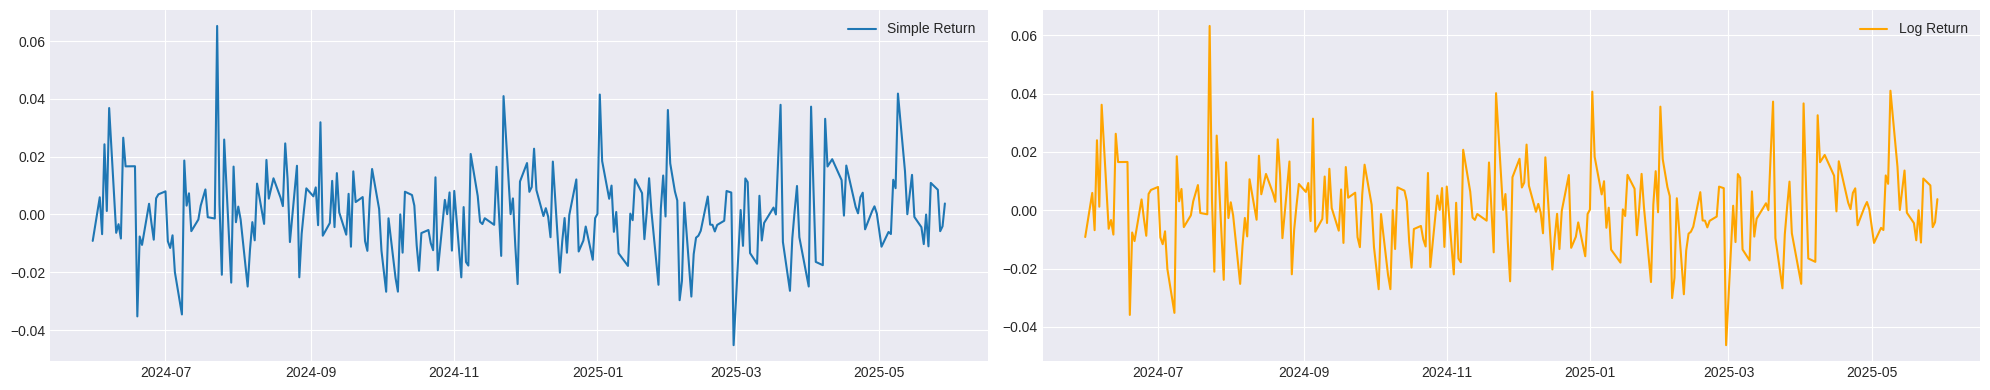

In [ ]:
data['Simple Return'] = data['Close'].pct_change()
data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))

# Plotting both returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), sharex=True)
ax1.plot(data['Simple Return'], label="Simple Return")
ax1.legend()
ax2.plot(data['Log Return'], color='orange', label="Log Return")
ax2.legend()
plt.tight_layout()
plt.show()


Why do they look similar? When might they differ significantly?

*   Simple vs Log Returns: They look similar because the changes are small. For large returns, log returns are more accurate due to compounding effects.

*   Difference significance: When returns are large (e.g., in crypto or during extreme market events), the two diverge more.



2. Volatility Estimation

Compute rolling 14-day volatility (standard deviation of daily returns). Plot it along with price.

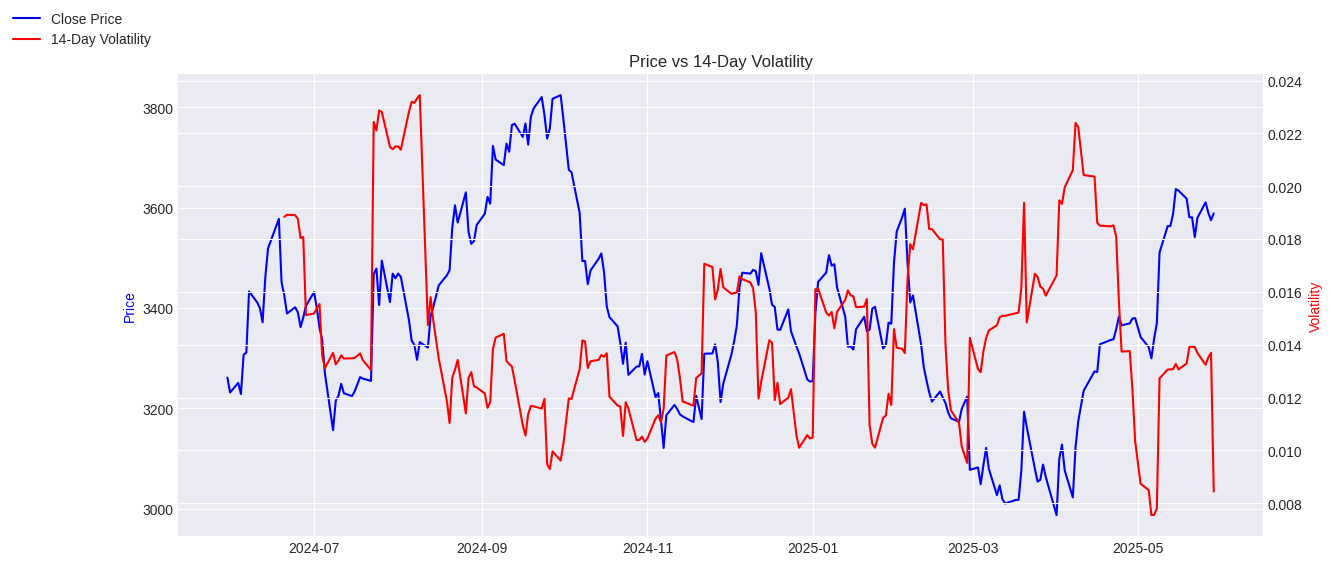

In [22]:
data['Rolling Volatility'] = data['Simple Return'].rolling(window=14).std()

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(data['Close'], label='Close Price', color='blue')
ax1.set_ylabel('Price', color='blue')

ax2 = ax1.twinx()
ax2.plot(data['Rolling Volatility'], label='14-Day Volatility', color='red')
ax2.set_ylabel('Volatility', color='red')

fig.legend(loc='upper left')
plt.title("Price vs 14-Day Volatility")
plt.show()

### Problem Statement 3: The Probability Paradox

#### Part 1: Theory vs Reality

In [26]:
from scipy.stats import binom

# Step 1: Classify days
data['Direction'] = data['Simple Return'].apply(lambda x: 'UP' if x > 0 else 'DOWN')
p_up = (data['Direction'] == 'UP').mean()
print(f"P(UP) = {p_up:.2f}")

# Step 2: Binomial probabilities
n = 10
p_6_up = binom.pmf(6, n, p_up)
p_at_least_8_up = binom.sf(7, n, p_up)  # sf = 1 - cdf(7)
print(f"P(Exactly 6 UP days in 10): {p_6_up:.4f}")
print(f"P(At least 8 UP days in 10): {p_at_least_8_up:.4f}")

P(UP) = 0.50
P(Exactly 6 UP days in 10): 0.2083
P(At least 8 UP days in 10): 0.0576


Simulation

In [28]:
np.random.seed(42)
simulations = np.array([np.random.binomial(n, p_up) for _ in range(1000)])

p_6_up = np.sum(simulations == 6)
p_at_least_8_up = np.sum(simulations >= 8)

print(f"Simulated P(exactly 6 UP days): {p_6_up / 1000:.4f}")
print(f"Simulated P(at least 8 UP days): {p_at_least_8_up / 1000:.4f}")

Simulated P(exactly 6 UP days): 0.2030
Simulated P(at least 8 UP days): 0.0620


#### Part 2: Even with 6 UP days, you can lose money

In [30]:
up_avg = data[data['Direction'] == 'UP']['Simple Return'].mean()
down_avg = data[data['Direction'] == 'DOWN']['Simple Return'].mean()

# Assume 6 UP and 4 DOWN days
total_return = 6 * up_avg + 4 * down_avg
print(f"Avg UP Return: {up_avg:.4%}")
print(f"Avg DOWN Return: {down_avg:.4%}")
print(f"Total return for 6 UP, 4 DOWN: {total_return:.5f}")

Avg UP Return: 1.1373%
Avg DOWN Return: -1.0649%
Total return for 6 UP, 4 DOWN: 0.02564


Even if 60% of the days are UP, if down days have steeper losses, the overall return can still be negative.small consistent gains can’t compensate for sharp downfalls.

#### Part 3: The Ultimate Question

In [32]:
win = 100
loss = -150

expected_value = p_up * win + (1 - p_up) * loss
print(f"Expected Value of Bet: ₹{expected_value:.2f}")

Expected Value of Bet: ₹-23.99


If expected value is negative, this is a losing bet. Even with 60% win rate, large losses on down days make it unfavorable. I wouldn’t take the bet unless I had more favorable payout odds.

**Optional:**

I wanted to learn about finance and wanted to do project in finance related field so, i am expecting to become proficient in finance and python after completion of this project.

Yes, i am happy with allotment of this project.

I read the what you will learn section and this section got my attention that i will learn about stocks, finance and bayesian thats why i put this in top preference.